# TEDx

In [58]:
import os
import pandas as pd
import docx
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unidecode
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

Create db

In [2]:
def get_text(filename):
    doc = docx.Document(filename)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

In [3]:
df = pd.DataFrame(columns=['file', 'text'])

In [4]:
directory = 'data/'

In [5]:
for root, subdirs, files in os.walk(directory):
    print('--\nroot = ' + root)
    list_file_path = os.path.join(root, 'my-directory-list.txt')
    print('list_file_path = ' + list_file_path)

    with open(list_file_path, 'wb') as list_file:
        for subdir in subdirs:
            print('\t- subdirectory ' + subdir)

        for filename in files:
            file_path = os.path.join(root, filename)
            if filename.endswith(".docx"): 
                print("docx!")
                print(file_path)
                text = get_text(file_path)
                lines = []
                pattern = re.compile("[0-9]{1,2}:[0-9]{2}")
                for a_line in text.split('\n'):
                    if not pattern.match(a_line):
                        lines.append(a_line)
                text = "\n".join(lines)
            elif filename.endswith('.txt'):
                print("txt!")
                print(file_path) 
                with open(file_path, 'r') as f:
                    text = f.read()
#                     first_line = text.split('\n')[0]
#                     second_line = text.split('\n')[1]
#                     if first_line.lower().startswith("traductor") and second_line.lower().startswith("revisor"):
#                         text = "\n".join(text.split('\n')[2:])
            else:
                continue

            data = pd.DataFrame({"file": [filename], "text": [text]})
            df = df.append(data, ignore_index=True)

--
root = data/
list_file_path = data/my-directory-list.txt
	- subdirectory 2013
	- subdirectory 2014
	- subdirectory 2015
	- subdirectory 2012
	- subdirectory 2017
	- subdirectory 2010
	- subdirectory 2018
	- subdirectory 2011
	- subdirectory 2016
txt!
data/my-directory-list.txt
--
root = data/2013
list_file_path = data/2013/my-directory-list.txt
txt!
data/2013/Quien_es_Dios_para_mi_Margarita_Barrientos_2013.txt
txt!
data/2013/Neurociencia_para_todos_Timothy_Marzullo_2013.txt
txt!
data/2013/Prisioneros_de_nuestros_propios_recursos_Jonathan_Levav_2013.txt
txt!
data/2013/Genetica_y_derechos_humanos_Victor_Penchaszadeh_2013.txt
txt!
data/2013/El_corazon_de_una_mujer_puede_romperse_en_serio_Florencia_Rolandi_2013.txt
txt!
data/2013/El_ultimo_de_los_Brenman_Esteban_Brenman_2013.txt
txt!
data/2013/Cinco_por_ciento_Andy_Freire_2013.txt
txt!
data/2013/El_lado_sucio_de_la_limpieza_David_Pizarro_2013.txt
txt!
data/2013/Contando_desde_los_margenes_Jose_Luis_Gallego_2013.txt
txt!
data/2013/my-dir

Clean db

In [6]:
df = df.drop(df[df['file'] == 'my-directory-list.txt'].index).reset_index(drop=True)

In [7]:
df.sample(5)

,file,text
103,La_biologia_y_el_septimo_arte_Fabian_Gabelli20...,[Fabián Gabelli] \n[La biología y el séptimo a...
11,Vivir_del_aire_Lalo_Mir_2013.txt,(Música)\n(Aplausos)\nGracias. Muy amables.\nN...
215,De_que_hablan_los_delfines_Marcelo_Magnasco201...,Déjenme contarles una historia\nde cuando yo e...
209,Himno_Nacional_Argentino_Sergio_Feferovich_y_V...,"Vamos a ensayar juntos,\nprimero bien sentados..."
127,Puta_y_feminista_Cronica_de_una_trabajadora_se...,Tenía 25 años y necesitaba\nvolver a trabajar....


In [8]:
aclarations = ['(Risas)', '(Aplausos)', '(Palmas)', '(Silbidos)', '(Fin de aplausos)', 
               '(Exhalación)', '(Canta) ', '(Agita un frasco)', '(Actúa)', '(Fin de actuación)',
               '(Video)', '(Fin del Video)', '(Inicia música de fondo)', '(Cesa la música de fondo)', 
               '(Música de fondo)', '(Sonido de radio sin sintonizar)', '(Fin de sintonización)',
               '(Tintineo de monedas)', '(Sonido de teléfono a disco)', '(Guitarra)', 
               '(Fusión de sonidos auto-repetitivos)', '(Tose)', '(Galimatías)', '(Beatbox)',
               '(Sonido de radio sintonizada)', '(Ovaciones)', '(Mueca imitando a la rana)',
               '(Imita sonido)', '(Inglés)',re.compile(r"--.*--"), re.compile(r"♪.*♪")]


for an_aclaration in aclarations:
    df['text'] = df['text'].str.replace(an_aclaration, ' ')

df['text'] = df['text'].str.replace("\n", ' ')
df['words'] = df.text.str.strip().str.split('[\W_]+')
rows = list()
for row in df[['words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((word))

words = pd.DataFrame(rows, columns=['word'])
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
counts = words.word.value_counts().to_frame().rename(columns={'word':'count_per_word'})

stopwords = stopwords.words('spanish')
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)
        
drop_list = ['aplausos', 'si', 'entonces', 'así', 'risas']
for a_word in counts.index:
    if unidecode.unidecode(a_word) in stopwords:
        drop_list.append(a_word)

counts = counts.drop(drop_list)
top_20 = counts.head(20)

In [13]:
stopset = set(stopwords + drop_list)
TED_TALK_DURATION = 20 * 60 # SECONDS. (20 min each ted talk)
df['tokens'] = pd.Series(dtype=object)
for index, row in df.iterrows():
    tokens = word_tokenize(row['text'])
    tokens_wo_stopwords = [word for word in tokens if not word in stopset]
    df.at[index, 'tokens'] = tokens_wo_stopwords
    df.at[index, 'le_d'] = ( len(tokens_wo_stopwords) / len(tokens) ) * 100
    df.at[index, 'ly_d'] = len(tokens) / TED_TALK_DURATION
    df.at[index, 'n_words'] = len(tokens)
    df.at[index, 'n_words_no_rep'] = len(list(set(tokens)))


In [43]:
df = pd.read_csv("raw_df.csv", sep='|').reset_index(drop=True)
df.head()

,Unnamed: 0,file,title,speaker,year,text,words,tokens,le_d,ly_d,n_words,n_words_no_rep
0,0,Quien_es_Dios_para_mi_Margarita_Barrientos_201...,Quien es Dios para mi,Margarita Barrientos,2013,( ) Soy santiagueña. He venido hace muchos año...,"['', 'Soy', 'santiagueña', 'He', 'venido', 'ha...","['(', ')', 'Soy', 'santiagueña', '.', 'He', 'v...",57.944415,1.589167,1907,580
1,1,Neurociencia_para_todos_Timothy_Marzullo_2013.txt,Neurociencia para todos,Timothy Marzullo,2013,Supongamos que estás interesado en la neurocie...,"['Supongamos', 'que', 'estás', 'interesado', '...","['Supongamos', 'interesado', 'neurociencia', '...",60.936408,2.385000,2862,926
2,2,Prisioneros_de_nuestros_propios_recursos_Jonat...,Prisioneros de nuestros propios recursos,Jonathan Levav,2013,"En la vida, algunas decisiones son muy fáciles...","['En', 'la', 'vida', 'algunas', 'decisiones', ...","['En', 'vida', ',', 'decisiones', 'fáciles', '...",63.328956,2.538333,3046,920
3,3,Genetica_y_derechos_humanos_Victor_Penchaszade...,Genetica y derechos humanos,Victor Penchaszadeh,2013,En noviembre de 1982 me encontré en la ciudad ...,"['En', 'noviembre', 'de', '1982', 'me', 'encon...","['En', 'noviembre', '1982', 'encontré', 'ciuda...",56.769596,1.754167,2105,740
4,4,El_corazon_de_una_mujer_puede_romperse_en_seri...,El corazón de una mujer puede romperse en serio,Florencia Rolandi,2013,( ) ¿De qué se mueren los hombres? La primera ...,"['', 'De', 'qué', 'se', 'mueren', 'los', 'homb...","['(', ')', '¿De', 'mueren', 'hombres', '?', 'L...",57.454545,1.833333,2200,679


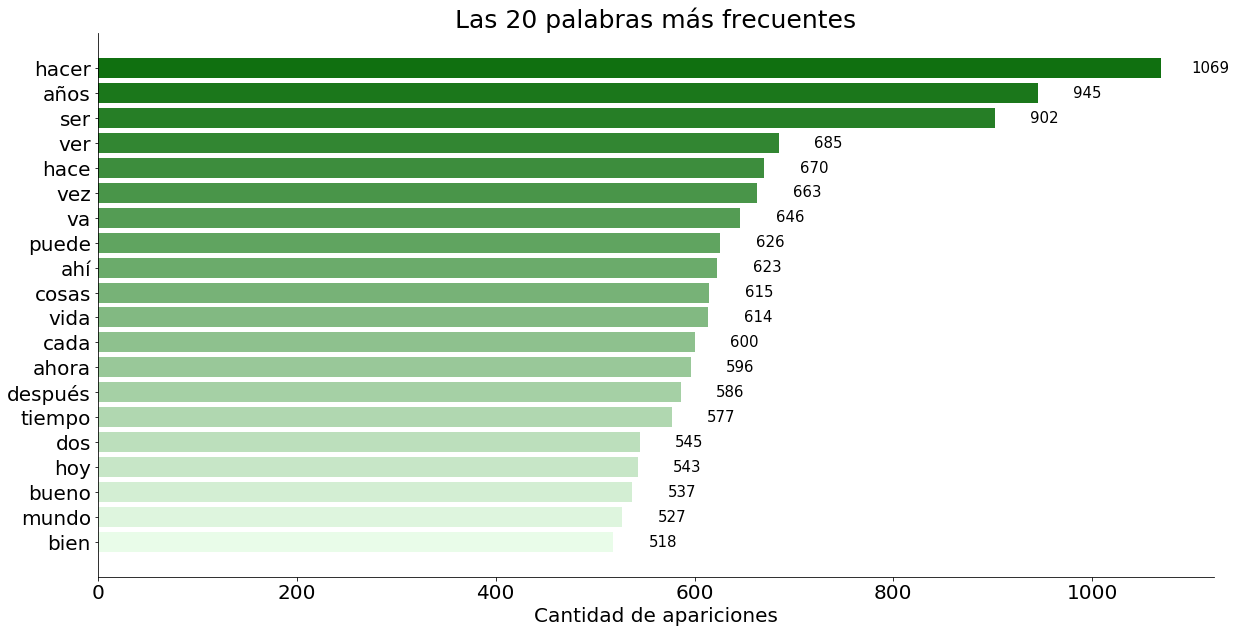

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="count_per_word", y=top_20.index, data=top_20, palette=sns.light_palette("green", n_colors=20, reverse=True))
plt.ylabel("")
plt.xlabel('Cantidad de apariciones', fontsize=20)
plt.title('Las 20 palabras más frecuentes', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 50  ,
            p.get_y() + p.get_height()/1.4,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

In [45]:
head = counts.head(200)
to_plot = list(zip(head.index, head['count_per_word']))

In [46]:
def plot_wordcloud_from_list(a_list, title=None):
    if not title:
        title = "img_%d.jpg" % math.random.uniform(1, 12321)
    freqs_by_words = {}
    for a_topic_term in a_list:
        an_actual_word = a_topic_term[0]
        freqs_by_words[an_actual_word] = a_topic_term[1]

    wc = WordCloud(background_color="white", max_words=2000, max_font_size=100,)
    # generate word cloud
    wc.generate_from_frequencies(freqs_by_words)

    #show
    plt.figure(figsize=(15,10))
    plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()


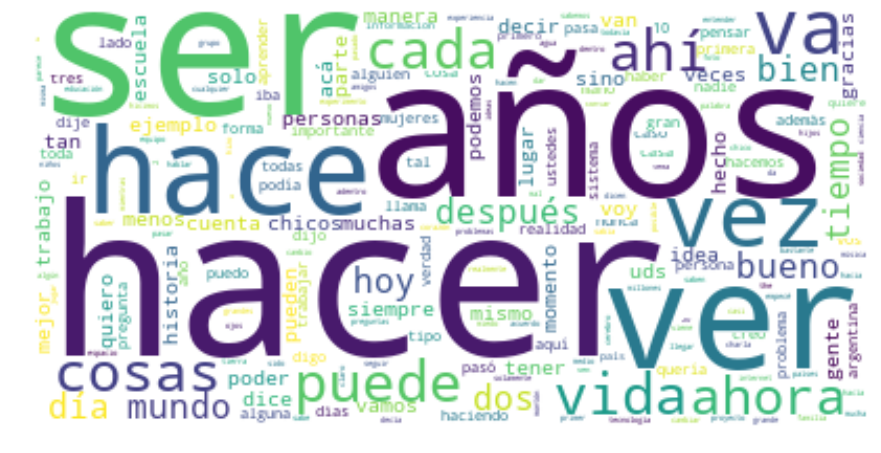

In [47]:
plot_wordcloud_from_list(to_plot, "wordcloud")

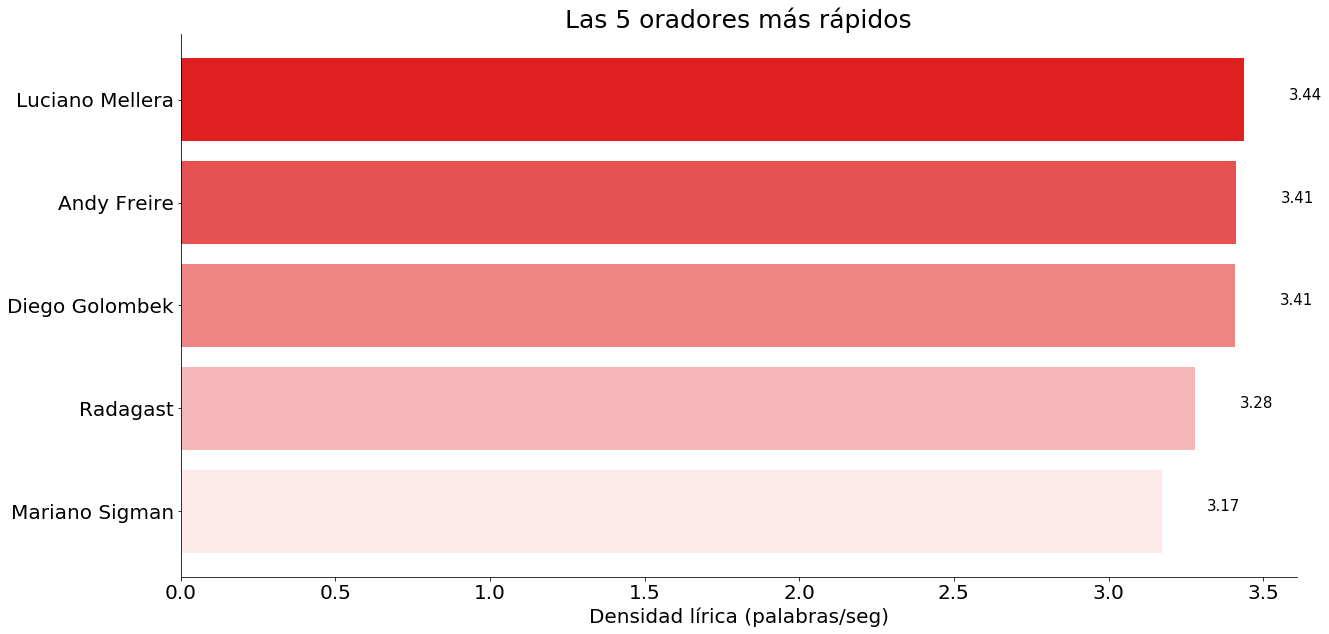

In [48]:
faster_speakers = df.sort_values("ly_d", ascending=False)[:5]


fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="ly_d", y='speaker', data=faster_speakers, palette=sns.light_palette("red", n_colors=5, reverse=True))
plt.ylabel("")
plt.xlabel('Densidad lírica (palabras/seg)', fontsize=20)
plt.title('Las 5 oradores más rápidos', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + .2  ,
            p.get_y() + p.get_height()/2.,
            "%.02f" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

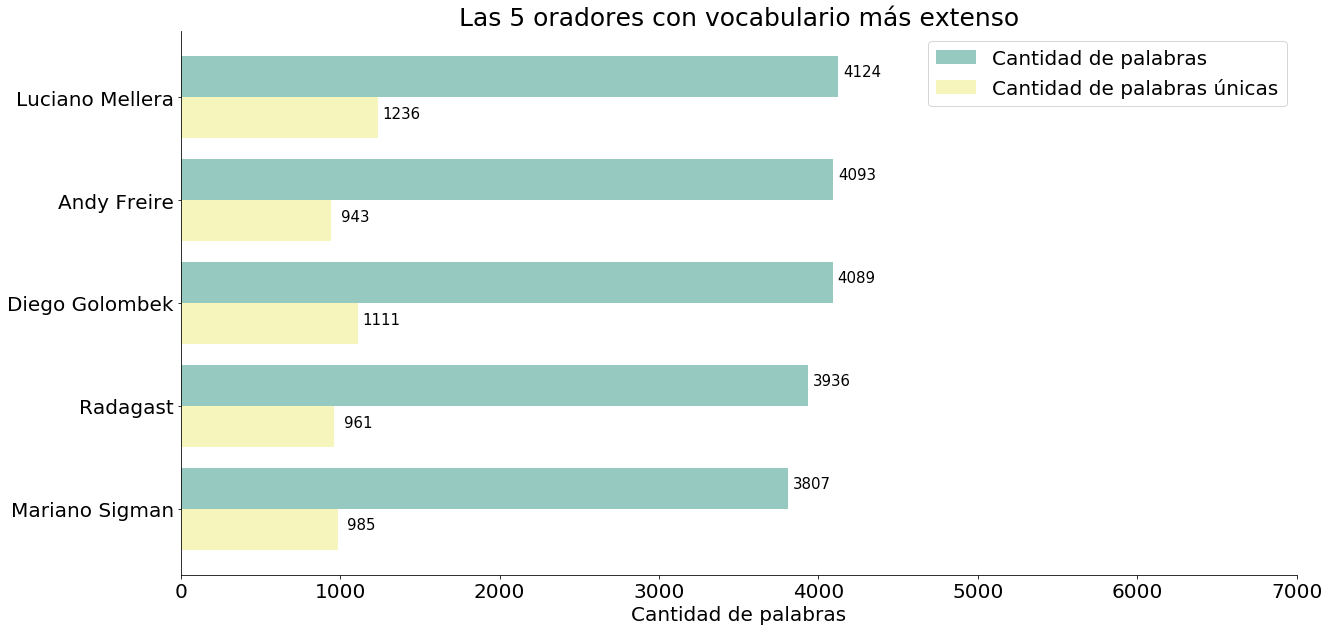

In [51]:
more_vocab = df.sort_values("n_words", ascending=False)[:5]
more_vocab = more_vocab[['speaker', 'n_words', 'n_words_no_rep']]
more_vocab.columns = ['speaker', 'Cantidad de palabras', 'Cantidad de palabras únicas']

more_vocab = (
    more_vocab.set_index('speaker')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)



fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="Value", y='speaker', hue='Variable', data=more_vocab, palette="Set3")
plt.ylabel("")
plt.xlabel('Cantidad de palabras', fontsize=20)
plt.title('Las 5 oradores con vocabulario más extenso', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 150  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
ax.legend(prop={'size': 20})
plt.xlim(0,7000)
sns.despine()
plt.plot();

In [52]:
df.to_csv('raw_df.csv', sep='|')

In [53]:
#df = pd.read_csv("raw_df.csv", sep='|').reset_index(drop=True)
# df.head()

In [54]:
# df.columns =['to_drop', 'file', 'title', 'speaker', 'year', 'text',
#       'words', 'tokens', 'le_d', 'ly_d', 'n_words', 'n_words_no_rep']
# df = df.drop(['to_drop'], axis=1)

In [55]:
#df.head()

In [86]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    print("NMF")
    for topic_idx, topic in enumerate(H):
        print()
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(df.iloc[doc_index]['title'],df.iloc[doc_index]['speaker'])

In [84]:
documents = df.text

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=list(stopset))
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


no_topics = 20

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

no_top_words = 10
no_top_words = 10
no_top_documents = 4


In [87]:
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

NMF

Topic 0:
años hacer ser cosas ahí va vida vez ver cada
Río de las ideas Luciano Mellera
Despertar solidario Andy Kusnetzoff
El último de los Brenman Esteban Brenman
Vivir hasta morir Matias Najun

Topic 1:
escuela alumnos escuelas educación aprender profesores aula modelo niños grado
Una escuela en movimiento Teresa Punta
Un recreo tan loco como ideal Silvana Corso
Zombies en la escuela Juli Garbulsky
Dos caminos hacia la justicia educativa Axel Rivas

Topic 2:
miedo luz padres canción hijo escena va bien ahí quieren
Criar sin miedo Miguel Espeche
nan Luis Pescetti
Téstigos de la historia Teresa Bo
Negociar vida por sexo Ines Hercovich

Topic 3:
mujeres mujer hombres hombre sexual derechos tener existen sociedad riesgo
El corazón de una mujer puede romperse en serio Florencia Rolandi
No se nace feminista Dora Barrancos
Alla donde las mujeres mandan Ricardo Coler
Un cerebro mas liviano Nadia Chiaramoni

Topic 4:
cerebro neuronas experimento tarea comportamiento educación método con

Me gustó mas NMF

- 1/7/17
- 3
- 4
- 6/18
- 10
- 11
- 14
- 15
